# Alternative link functions for Binary response GLM

In [116]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.lines import Line2D
from scipy.special import expit as invlogit
from scipy.stats import norm

In [2]:
az.style.use("arviz-darkgrid")
np.random.seed(1234)

## Load and examine American National Election Studies (ANES) data

In [3]:
data = pd.read_csv("data/ANES_2016_pilot.csv")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


## Build `clinton_model`

To keep this simple, let's look at only the data from people who indicated that they would vote for either Clinton or Trump, and we'll model the probability of voting for Clinton.

In [4]:
clinton_data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [35]:
formula = "vote['clinton'] ~ party_id + party_id:age"

### Logit link

In [47]:
model_logit = bmb.Model(formula, clinton_data, family="bernoulli")
fitted_logit = clinton_model.fit(draws=2000)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [party_id:age, party_id, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 10 seconds.


### Probit link

In [48]:
model_probit = bmb.Model(formula, clinton_data, family="bernoulli", link="probit")
fitted_probit = clinton_model.fit(draws=2000)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [party_id:age, party_id, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 11 seconds.


### Cloglog link

In [84]:
model_cloglog = bmb.Model(formula, clinton_data, family="bernoulli", link="cloglog")
fitted_cloglog = clinton_model.fit(draws=2000)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [party_id:age, party_id, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 11 seconds.


## Spaghetti plot of model predictions

Here we separate results into two, one containing the intercept for each `party_id`, the other containing the `age` slopes for each `party_id`. Then we compute the linear predictor $\eta$ for the different party affiliations and a sequence of `age` values, and plot the estimated values for $\pi$ after passing $\eta$ to `invlogit()`.

In [49]:
age = np.arange(18, 91)
X = np.hstack([np.array([1] * len(age))[:, None], age[:, None]])

### Predictions for logit link

In [67]:
slopes = fitted_logit.posterior["party_id:age"].values.reshape(4000, 3).T

intercept_dem = fitted_logit.posterior["Intercept"].values.reshape(-1,)
intercept_rep = intercept_dem + fitted_logit.posterior["party_id"][:,:,0].values.reshape(-1,)
intercept_ind = intercept_dem + fitted_logit.posterior["party_id"][:,:,1].values.reshape(-1,)

intercepts = [intercept_dem, intercept_rep, intercept_ind]

yhat_logit = [invlogit(np.dot(X, np.vstack([intercepts[i], slopes[i]]))) for i in range(3)]
mu_logit = [yhat.mean(1) for yhat in yhat_logit]

### Predictions for probit link

In [68]:
slopes = fitted_probit.posterior["party_id:age"].values.reshape(4000, 3).T

intercept_dem = fitted_probit.posterior["Intercept"].values.reshape(-1,)
intercept_rep = intercept_dem + fitted_probit.posterior["party_id"][:,:,0].values.reshape(-1,)
intercept_ind = intercept_dem + fitted_probit.posterior["party_id"][:,:,1].values.reshape(-1,)

intercepts = [intercept_dem, intercept_rep, intercept_ind]

yhat_probit = [norm.cdf(np.dot(X, np.vstack([intercepts[i], slopes[i]]))) for i in range(3)]
mu_probit = [yhat.mean(1) for yhat in yhat_probit]

#### Predictions for cloglog link

In [85]:
def cloglog(x):
    return 1 - np.exp(-np.exp(x))

In [96]:
slopes = fitted_cloglog.posterior["party_id:age"].values.reshape(4000, 3).T

intercept_dem = fitted_cloglog.posterior["Intercept"].values.reshape(-1,)
intercept_rep = intercept_dem + fitted_cloglog.posterior["party_id"][:,:,0].values.reshape(-1,)
intercept_ind = intercept_dem + fitted_cloglog.posterior["party_id"][:,:,1].values.reshape(-1,)

intercepts = [intercept_dem, intercept_rep, intercept_ind]

yhat_cloglog = [cloglog(np.dot(X, np.vstack([intercepts[i], slopes[i]]))) for i in range(3)]
mu_cloglog = [yhat.mean(1) for yhat in yhat_cloglog]

Make the plot!

In [97]:
yhat = [yhat_logit, yhat_probit, yhat_cloglog]
mu = [mu_logit, mu_probit, mu_cloglog]

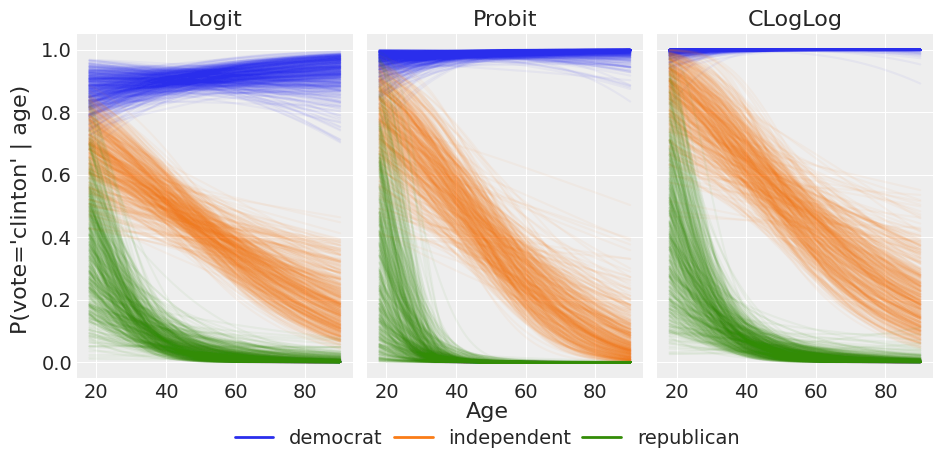

In [183]:
lines = [Line2D([0], [0], color=f"C{i}", linewidth=2) for i in range(3)]
labels = ["democrat", "independent", "republican"]

fig, ax = plt.subplots(1, 3, figsize=(9, 4), sharex=True, sharey=True)

links = ["Logit", "Probit", "CLogLog"]

for i, link in enumerate(links):
    for j in range(3):
        for t in range(500):
            ax[i].plot(age, yhat[i][j][:, t], alpha=0.05, color=f"C{j}")
    ax[i].set_title(f"{link}")


fig.text(0.5, -0.03, "Age", ha="center", fontsize=16)
fig.text(-0.03, 0.5, "P(vote='clinton' | age) ", va="center", rotation="vertical", fontsize=16)
fig.legend(lines, labels, ncol=3, bbox_to_anchor=(0.2, -0.15, 0.6, 0.2), loc="lower left", mode="expand");

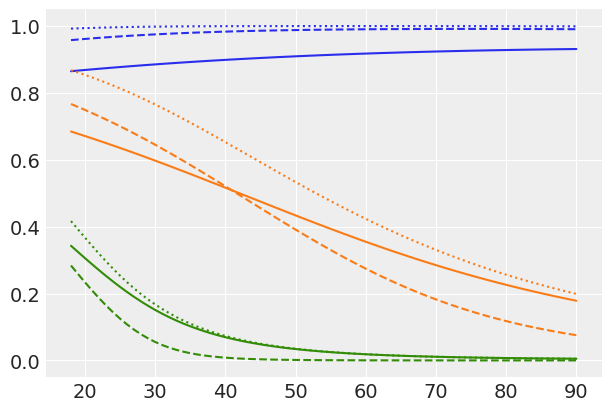

In [101]:
fig, ax = plt.subplots(figsize=(6, 4))
linestyles = ["-", "--", ":"]

for i, ls in enumerate(linestyles):
    for j in range(3):
        ax.plot(age, mu[i][j], color=f"C{j}", linestyle=ls)

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Apr 28 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

bambi     : 0.4.1
arviz     : 0.11.2
matplotlib: 3.3.3
numpy     : 1.20.1
pandas    : 1.2.2
json      : 2.0.9

Watermark: 2.1.0

